### Initialization
Installing requirements, auto reload changing to code, imports and some configurations

In [4]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import dice_ml

import multiprocessing

from copy import deepcopy

import time

import json

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [7]:
# disable tqdm progress bar by default
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

### Define research parameters

In [8]:
regression_task = False
continuous_features = ['Age', 'Credit amount', 'Duration']
metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']
test_size_proportion = 0.33
augment_sample = 0.5

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random', 'kw_args': {'total_CFs': 10}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 7, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 7, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2,
                                         'total_CFs': 10}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

### Read and preprocess data

In [9]:
raw_data = pd.read_csv(r"../datasets/german_credit.csv", index_col=0)
df = utils.preprocess_german(raw_data)
target = 'Risk'

#### split data

In [10]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

In [11]:
display(y_train.value_counts())

1    471
0    199
Name: Risk, dtype: int64

In [12]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [13]:
print(f'whole adult dataset scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
whole_dataset_result_df

whole adult dataset scores:


whole                                        
           f1  accuracy precision    recall   roc_auc
lg   0.823529  0.727273  0.764925  0.943231  0.745212
rf   0.822669  0.706061  0.707547  1.000000  0.755502
xgb  0.815109  0.718182  0.748175  0.960699  0.766267

In [14]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### running experiments

In [15]:
from data_augmentaion.data_augmentator import DataAugmentor 

In [16]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
    utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])


    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

1 / 4, {'method': 'random'} 10.400625228881836 seconds for settings 0
2 / 4, {'method': 'smote'} 10.417179346084595 seconds for settings 1
3 / 4, {'method': 'cf_random', 'kw_args': {'total_CFs': 10}} model for cf f1 score: {'cf': {'f1': 0.82}}
0/272
50/272
100/272
150/272
200/272
250/272
model for cf f1 score: {'cf': {'f1': 0.82}}
0/335
50/335
100/335
150/335
200/335
250/335
300/335
103.01118397712708 seconds for settings 2
4 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2, 'total_CFs': 10}} model for cf f1 score: {'cf': {'f1': 0.82}}
0/272
50/272
100/272
150/272
200/272
250/272
model for cf f1 score: {'cf': {'f1': 0.82}}
0/335
349.0817813873291 seconds for settings 3

Total time: 472.9107699394226


# summary

In [17]:
full_results_df

whole                                         random balanced  \
           f1  accuracy precision    recall   roc_auc              f1   
lg   0.823529  0.727273  0.764925  0.943231  0.745212        0.759259   
rf   0.822669  0.706061  0.707547  1.000000  0.755502        0.775414   
xgb  0.815109  0.718182  0.748175  0.960699  0.766267        0.788546   

                                               random                      \
     accuracy precision    recall   roc_auc        f1  accuracy precision   
lg   0.684848  0.807882  0.711790  0.739850  0.827038  0.736364  0.759124   
rf   0.712121  0.841837  0.716157  0.758680  0.824399  0.712121  0.714744   
xgb  0.718182  0.809091  0.781659  0.737775  0.826347  0.736364  0.761029   

                        smote balanced                                \
       recall   roc_auc             f1  accuracy precision    recall   
lg   0.938865  0.752432       0.785219  0.718182  0.825871  0.742358   
rf   0.991266  0.754118       0.791946  0.718182  0.811927  0.772926   
xgb  0.908297  0.748843       0.812362  0.742424  0.821429  0.799127   

                  smote                                          \
      roc_auc        f1  accuracy precision    recall   roc_auc   
lg   0.749276  0.785219  0.718182  0.825871  0.742358  0.749276   
rf   0.769770  0.791946  0.718182  0.811927  0.772926  0.769770   
xgb  0.762506  0.812362  0.742424  0.821429  0.799127  0.762506   

    cf_random balanced                                         cf_random  \
                    f1  accuracy precision    recall   roc_auc        f1   
lg            0.774775  0.696970  0.800000  0.751092  0.741753  0.776256   
rf            0.773455  0.700000  0.812500  0.733624  0.744044  0.771363   
xgb           0.814655  0.739394  0.804255  0.825328  0.756215  0.813043   

                                            cf_genetic balanced            \
     accuracy precision    recall   roc_auc                  f1  accuracy   
lg   0.703030  0.813397  0.742358  0.742920            0.766744  0.693939   
rf   0.681818  0.818627  0.689956  0.745860            0.765550  0.703030   
xgb  0.739394  0.809524  0.799127  0.751589            0.790287  0.718182   

                                  cf_genetic                                \
    precision    recall   roc_auc         f1  accuracy precision    recall   
lg   0.813725  0.729258  0.735008   0.766055  0.675758  0.796117  0.729258   
rf   0.846561  0.711790  0.755264   0.764846  0.700000  0.850000  0.703057   
xgb  0.806306  0.781659  0.752778   0.795604  0.718182  0.800885  0.799127   

               
      roc_auc  
lg   0.725712  
rf   0.749687  
xgb  0.753145

In [18]:
print('best methods:')
display(utils.get_best_methods(full_results_df))

best methods:


,f1,accuracy,precision,recall,roc_auc
lg,random,random,smote balanced,whole,random
rf,random,smote balanced,cf_genetic,whole,smote balanced
xgb,random,smote balanced,smote balanced,whole,whole
overall,random,smote balanced,cf_genetic,whole,smote balanced


In [21]:
utils.save_results_as_latex_tables(full_results_df, task_name="cirrhosis")

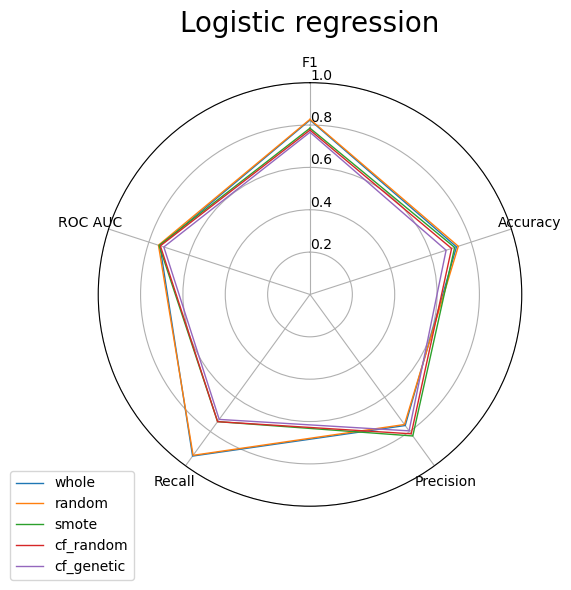

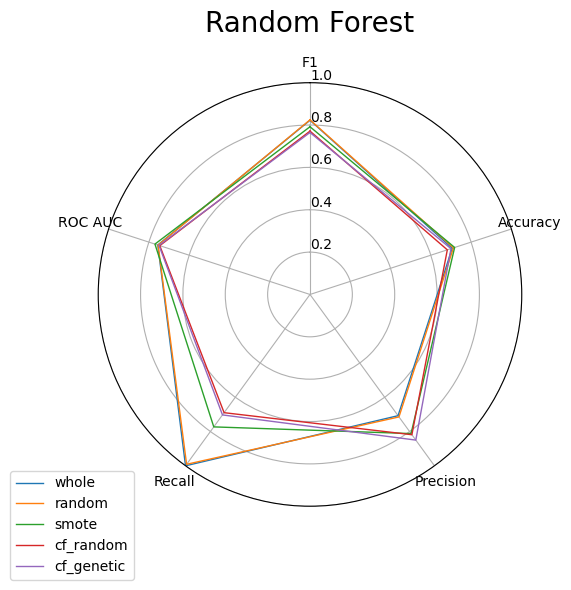

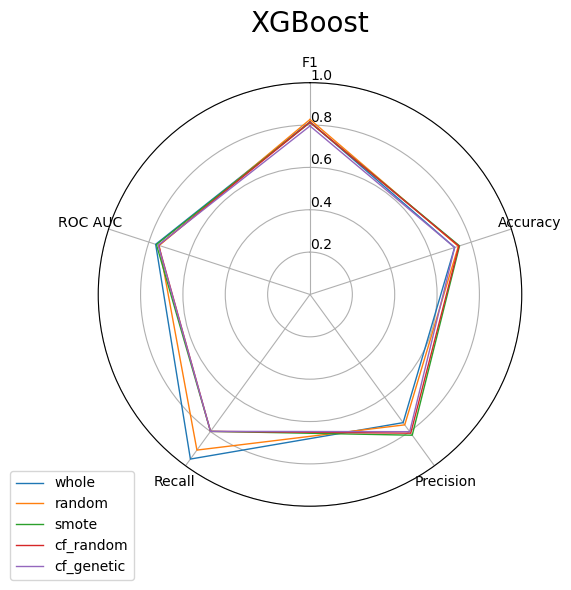

In [30]:
wanted_cols = ['whole', 'random','smote','cf_random','cf_genetic']
metric_names = {'f1': 'F1',
                'accuracy': 'Accuracy',
                'precision': 'Precision',
                'recall': 'Recall',
                'roc_auc': 'ROC AUC'}
utils.spider_plot(full_results_df, 'lg', wanted_cols, metric_names, 'Logistic regression', save_task_name='german')
utils.spider_plot(full_results_df, 'rf', wanted_cols, metric_names, 'Random Forest', save_task_name='german')
utils.spider_plot(full_results_df, 'xgb', wanted_cols, metric_names, 'XGBoost', save_task_name='german')

In [ ]:
full_results_df.to_csv(rf'../log/experiment_german.csv')